In [1]:
import os
import sys

parent_dir = os.path.dirname('/home/jupyter/')
sys.path.append(parent_dir)

import warnings
warnings.filterwarnings("ignore")

import gc
import time
import numpy as np
import pandas as pd
import scanpy as sc

import torch
import torch.nn.functional as F
torch.manual_seed(0)

from multivib.multiVIB import multivib, multivibLoRA
from multivib.multiVIB import multivib_vertical_training

from multivib.multiVIB import scale_by_batch

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

import matplotlib.pyplot as plt

# Prepare data for model training

In this tutorial, we will use the jointly-profiled mouse cortex data from Xu et al. as cell anchors and aim to integrate scRNA-seq data from Yao et al. and scATAC-seq data from Li et al.

In [2]:
file = "../data/mouse_cortex/mCortex_Xu_rna.h5ad"

ref_rna = sc.read_h5ad(file)
ref_rna.obs['use']='reference'
ref_rna.obs['study']='Xu et al. (RNA-seq)'
ref_rna.obs['source']='RNA-seq'

# sc.pp.normalize_total(ref_rna, target_sum=1e4)
# sc.pp.log1p(ref_rna)

ref_rna = ref_rna[:, ~ref_rna.var.index.duplicated()]

In [3]:
## Genomics modality window bin matrix
file = "../data/mouse_cortex/mCortex_Xu_atac_window.h5ad"
ad = sc.read_h5ad(file)
ad.obs['use']='reference'
ad.obs['study']='Xu et al. (ATAC-seq)'
ad.obs['source']='ATAC-seq'

# preprocessing ATAC modality with tfidf transformation
tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
tfidf_data = tfidf_transformer.fit_transform(ad.X)
feature_scores = np.asarray(tfidf_data.sum(0)).squeeze()

ref_dna = sc.AnnData(X=tfidf_data)
ref_dna.obs = ad.obs
ref_dna.var = ad.var

# filter features to get the top 90 percentile of most frequent features
ref_dna = ref_dna[:, feature_scores > np.percentile(feature_scores, 90)]

print(ref_rna.X.shape)
print(ref_dna.X.shape)

(10361, 32285)
(10361, 10614)


In [4]:
file = "../data/mouse_cortex/mPFC_rna_full.h5ad"
query_rna = sc.read_h5ad(file)

# for demonstration, we only use a downsampled Yao et al. data
sc.pp.subsample(query_rna, fraction=0.5)

query_rna.obs['use']='query'
query_rna.obs['study']= np.asarray(query_rna.obs['assay'].values)
query_rna.obs['source']='RNA-seq'
query_rna.X = query_rna.raw.X.copy()

gene_names = [i.split('_')[0] for i in query_rna.var['feature_name'].values]
query_rna.var.index = gene_names
sc.pp.normalize_total(query_rna, target_sum=1e4)
sc.pp.log1p(query_rna)

query_rna = query_rna[:, ~query_rna.var.index.duplicated()]

In [5]:
## Genomics modality window bin matrix
file = "../data/mouse_cortex/Li_mouse_brain_atac.h5ad"
ad = sc.read_h5ad(file)
ad.obs['use']='query'
ad.obs['study']='Li et al.'
ad.obs['source']='ATAC-seq'
ad.obs['cell_type']=ad.obs['annotation']

# preprocessing ATAC modality with tfidf transformation
tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
tfidf_data = tfidf_transformer.fit_transform(ad.X)
feature_scores = np.asarray(tfidf_data.sum(0)).squeeze()

query_dna = sc.AnnData(X=tfidf_data)
query_dna.obs = ad.obs
query_dna.var = ad.var

In [6]:
## identify highly variable features in both modalities
sc.pp.highly_variable_genes(ref_rna, n_top_genes=3000, flavor='seurat', subset=True)
sc.pp.highly_variable_genes(ref_dna, n_top_genes=10000, flavor='seurat', subset=True)

adata_rna = ref_rna.concatenate(query_rna)
adata_dna = ref_dna.concatenate(query_dna)

In [7]:
del ref_rna, ref_dna , query_rna, query_dna
gc.collect()

2353

In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.expand_dims(
    adata_rna.obs['study'].values.tolist()+adata_dna.obs['study'].values.tolist(),
    axis=1))

rna_batch = enc.transform(np.expand_dims(adata_rna.obs['study'], 1))
dna_batch = enc.transform(np.expand_dims(adata_dna.obs['study'], 1))

rna_batch = np.asarray(rna_batch.todense())
dna_batch = np.asarray(dna_batch.todense())

rna_batch_paired = rna_batch[adata_rna.obs['use']=='reference',:]
dna_batch_paired = dna_batch[adata_dna.obs['use']=='reference',:]

In [9]:
print(rna_batch.shape)
print(dna_batch.shape)

(213454, 6)
(26675, 6)


In [10]:
##Scale data
X_rna = np.asarray(adata_rna.X.todense())
X_dna = np.asarray(adata_dna.X.todense())

X_rna = scale_by_batch(X_rna, adata_rna.obs['study'].values)
X_rna_paired = X_rna[adata_rna.obs['use']=='reference',:]

X_dna = scale_by_batch(X_dna, adata_dna.obs['study'].values)
X_dna_paired = X_dna[adata_dna.obs['use']=='reference',:]

In [11]:
integrater = multivibLoRA(
    n_input_a=X_rna.shape[1],
    n_input_b=X_dna.shape[1],
    n_hidden=128, n_latent=20,
    n_batch=6
)

In [12]:
start_time = time.time()

loss_history = multivib_vertical_training(
    integrater, 
    X_rna, X_dna, X_rna_paired, X_dna_paired,
    rna_batch, dna_batch, rna_batch_paired, dna_batch_paired,
    epoch=200, temp=0.15, batch_size=256, alpha=0.02,
)

print("--- %s minutes ---" % int((time.time() - start_time)/60))

--- 23 minutes ---


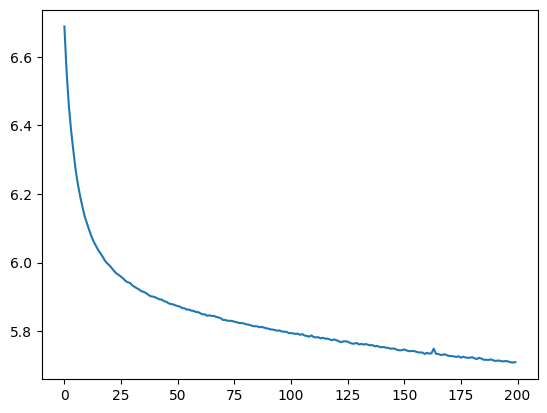

3558

In [13]:
plt.plot(loss_history, linestyle = 'solid')
plt.show()
gc.collect()

In [14]:
## save trained model
## when continue training on new data, we will start from the previously trained encoder
## depending on if the modality is new, translator is either starting from scratch or from previous training
PATH = "mousecortex_integration_atac.ckpt"
torch.save(integrater.state_dict(), PATH)

In [15]:
integrater.to(torch.device("cpu"))
integrater.eval()

X_tensor_A=torch.tensor(X_rna).float()
X_tensor_B=torch.tensor(X_dna).float()

_, z_a=integrater.encoder(X_tensor_A)
z_btoa=integrater.translator(X_tensor_B)
_, z_b=integrater.encoder(z_btoa)

z_a = torch.Tensor.cpu(z_a).detach().numpy()
z_b = torch.Tensor.cpu(z_b).detach().numpy()

In [16]:
adata = adata_rna.concatenate(adata_dna)
adata.obsm['X_multivib'] = np.concatenate((z_a, z_b),0)

In [17]:
sc.pp.neighbors(adata, use_rep='X_multivib', 
                n_neighbors=15, metric='correlation', method='umap')
sc.tl.umap(adata,min_dist=0.15)

In [18]:
## we are doing some manual relabeling of cell type to have the same format of naming
celltypes = np.array(adata.obs['BICCN_subclass_label'].values.tolist())
celltypes[celltypes=='nan']= adata.obs['cell_type'].values[celltypes=='nan']

celltypes[celltypes=='Astrocyte']='Astro'
celltypes[celltypes=='Endothelial cell']='Endo'
celltypes[celltypes=='L2/3']='L2/3 IT'
celltypes[celltypes=='L4']='L4'
celltypes[celltypes=='L5 IT neuron']='L5 IT'
celltypes[celltypes=='L6 CT neuron']='L6 CT'
celltypes[celltypes=='L6 IT neuron']='L6 IT'
celltypes[celltypes=='Lamp5 neuron']='Lamp5'
celltypes[celltypes=='Oligodendrocyte']='Oligo'
celltypes[celltypes=='Oligodendrocyte progenitor cell']='OPC'
celltypes[celltypes=='Pvalb neuron']='Pvalb'
celltypes[celltypes=='Smooth muscle cell']='SMC'
celltypes[celltypes=='Sncg neuron']='Sncg'
celltypes[celltypes=='Sst Chodl neuron']='Sst'
celltypes[celltypes=='Sst neuron']='Sst'
celltypes[celltypes=='Vip GABAergic neuron']='Vip'
celltypes[celltypes=='L6 IT Car3']='L6 IT'
celltypes[celltypes=='near-projecting']='NP'

celltypes[celltypes=='Astro_Myoc']='Astro'
celltypes[celltypes=='Astro_Nnat']='Astro'
celltypes[celltypes=='Oligo_MFOL']='Oligo'
celltypes[celltypes=='Oligo_MOL']='Oligo'

# celltype = adata.obs['cell_type'].values
celltypes[celltypes=='R1 Ex-L2/3 IT Act'] = 'L2/3 IT'
celltypes[celltypes=='R0 Ex-L2/3 IT'] = 'L2/3 IT'
celltypes[celltypes=='R3 Ex-L5 IT'] = 'L5 IT'
celltypes[celltypes=='R2 Ex-L4 IT'] = 'L4'

celltypes[celltypes=='R4 Ex-L5 NP'] = 'L5 NP'
celltypes[celltypes=='R5 Ex-L5 NP Cxcl14'] = 'L5 NP'
celltypes[celltypes=='R6 Ex-L5-PT'] = 'L5 PT'
celltypes[celltypes=='R7 Ex-L6 CT'] = 'L6 CT'

celltypes[celltypes=='R8 Ex-L6 IT Bmp3'] = 'L6 IT'
celltypes[celltypes=='R9 Ex-L6 IT Oprk1'] = 'L6 IT'
celltypes[celltypes=='R10 Ex-L6b'] = 'L6b'
celltypes[celltypes=='R11 Ex-PIR Ndst4'] = 'PIR'

celltypes[celltypes=='R12 Misc'] = 'Misc'
celltypes[celltypes=='R13 In-Drd2'] = 'Drd2'
celltypes[celltypes=='R14 In-Hap1'] = 'Hap1'
celltypes[celltypes=='R15 In-Pvalb'] = 'Pvalb'

celltypes[celltypes=='R16 In-Sst'] = 'Sst'
celltypes[celltypes=='R17 In-Tac1'] = 'Tac1'
celltypes[celltypes=='R18 In-Vip/Lamp5'] = 'Vip/Lamp5'
celltypes[celltypes=='R19 Astro'] = 'Astro'

celltypes[celltypes=='R20 OPC'] = 'OPC'
celltypes[celltypes=='R21 Oligo'] = 'Oligo'
celltypes[celltypes=='R22 VLMC'] = 'VLMC'


celltypes[celltypes=='ASC']='Astro'
celltypes[celltypes=='ITL23GL']='L2/3 IT'
celltypes[celltypes=='ITL4GL']='L4'
celltypes[celltypes=='ITL5GL']='L5 IT'

celltypes[celltypes=='ITL6GL']='L6 IT'
celltypes[celltypes=='PER']='Peri'
celltypes[celltypes=='OGC']='Oligo'
celltypes[celltypes=='PVGA']='Pvalb'

celltypes[celltypes=='Vip/Lamp5']='Lamp5'
celltypes[celltypes=='SSTGA']='Sst'

celltypes[celltypes=='Endothelial']='Endo'
celltypes[celltypes=='L23']='L2/3 IT'
celltypes[celltypes=='L4']='L4'
celltypes[celltypes=='L5']='L5 IT'
celltypes[celltypes=='CT']='L6 CT'
celltypes[celltypes=='L6']='L6 IT'
celltypes[celltypes=='PT']='L5 PT'
celltypes[celltypes=='PTGL']='L5 PT'
celltypes[celltypes=='NPGL']='L5 NP'
celltypes[celltypes=='NP']='L5 NP'
celltypes[celltypes=='L5/6 NP']='L5 NP'

celltypes[celltypes=='Endothelial']='Endo'
celltypes[celltypes=='L23']='L2/3 IT'
celltypes[celltypes=='L4']='L4'
celltypes[celltypes=='L5']='L5 IT'
celltypes[celltypes=='CT']='L6 CT'
celltypes[celltypes=='L6']='L6 IT'
celltypes[celltypes=='PT']='L5 PT'
celltypes[celltypes=='PTGL']='L5 PT'
celltypes[celltypes=='NPGL']='L5 NP'
celltypes[celltypes=='NP']='L5 NP'
celltypes[celltypes=='L5/6 NP']='L5 NP'
celltypes[celltypes=='CTGL']='L6 CT'

adata.obs['cell_type'] = celltypes

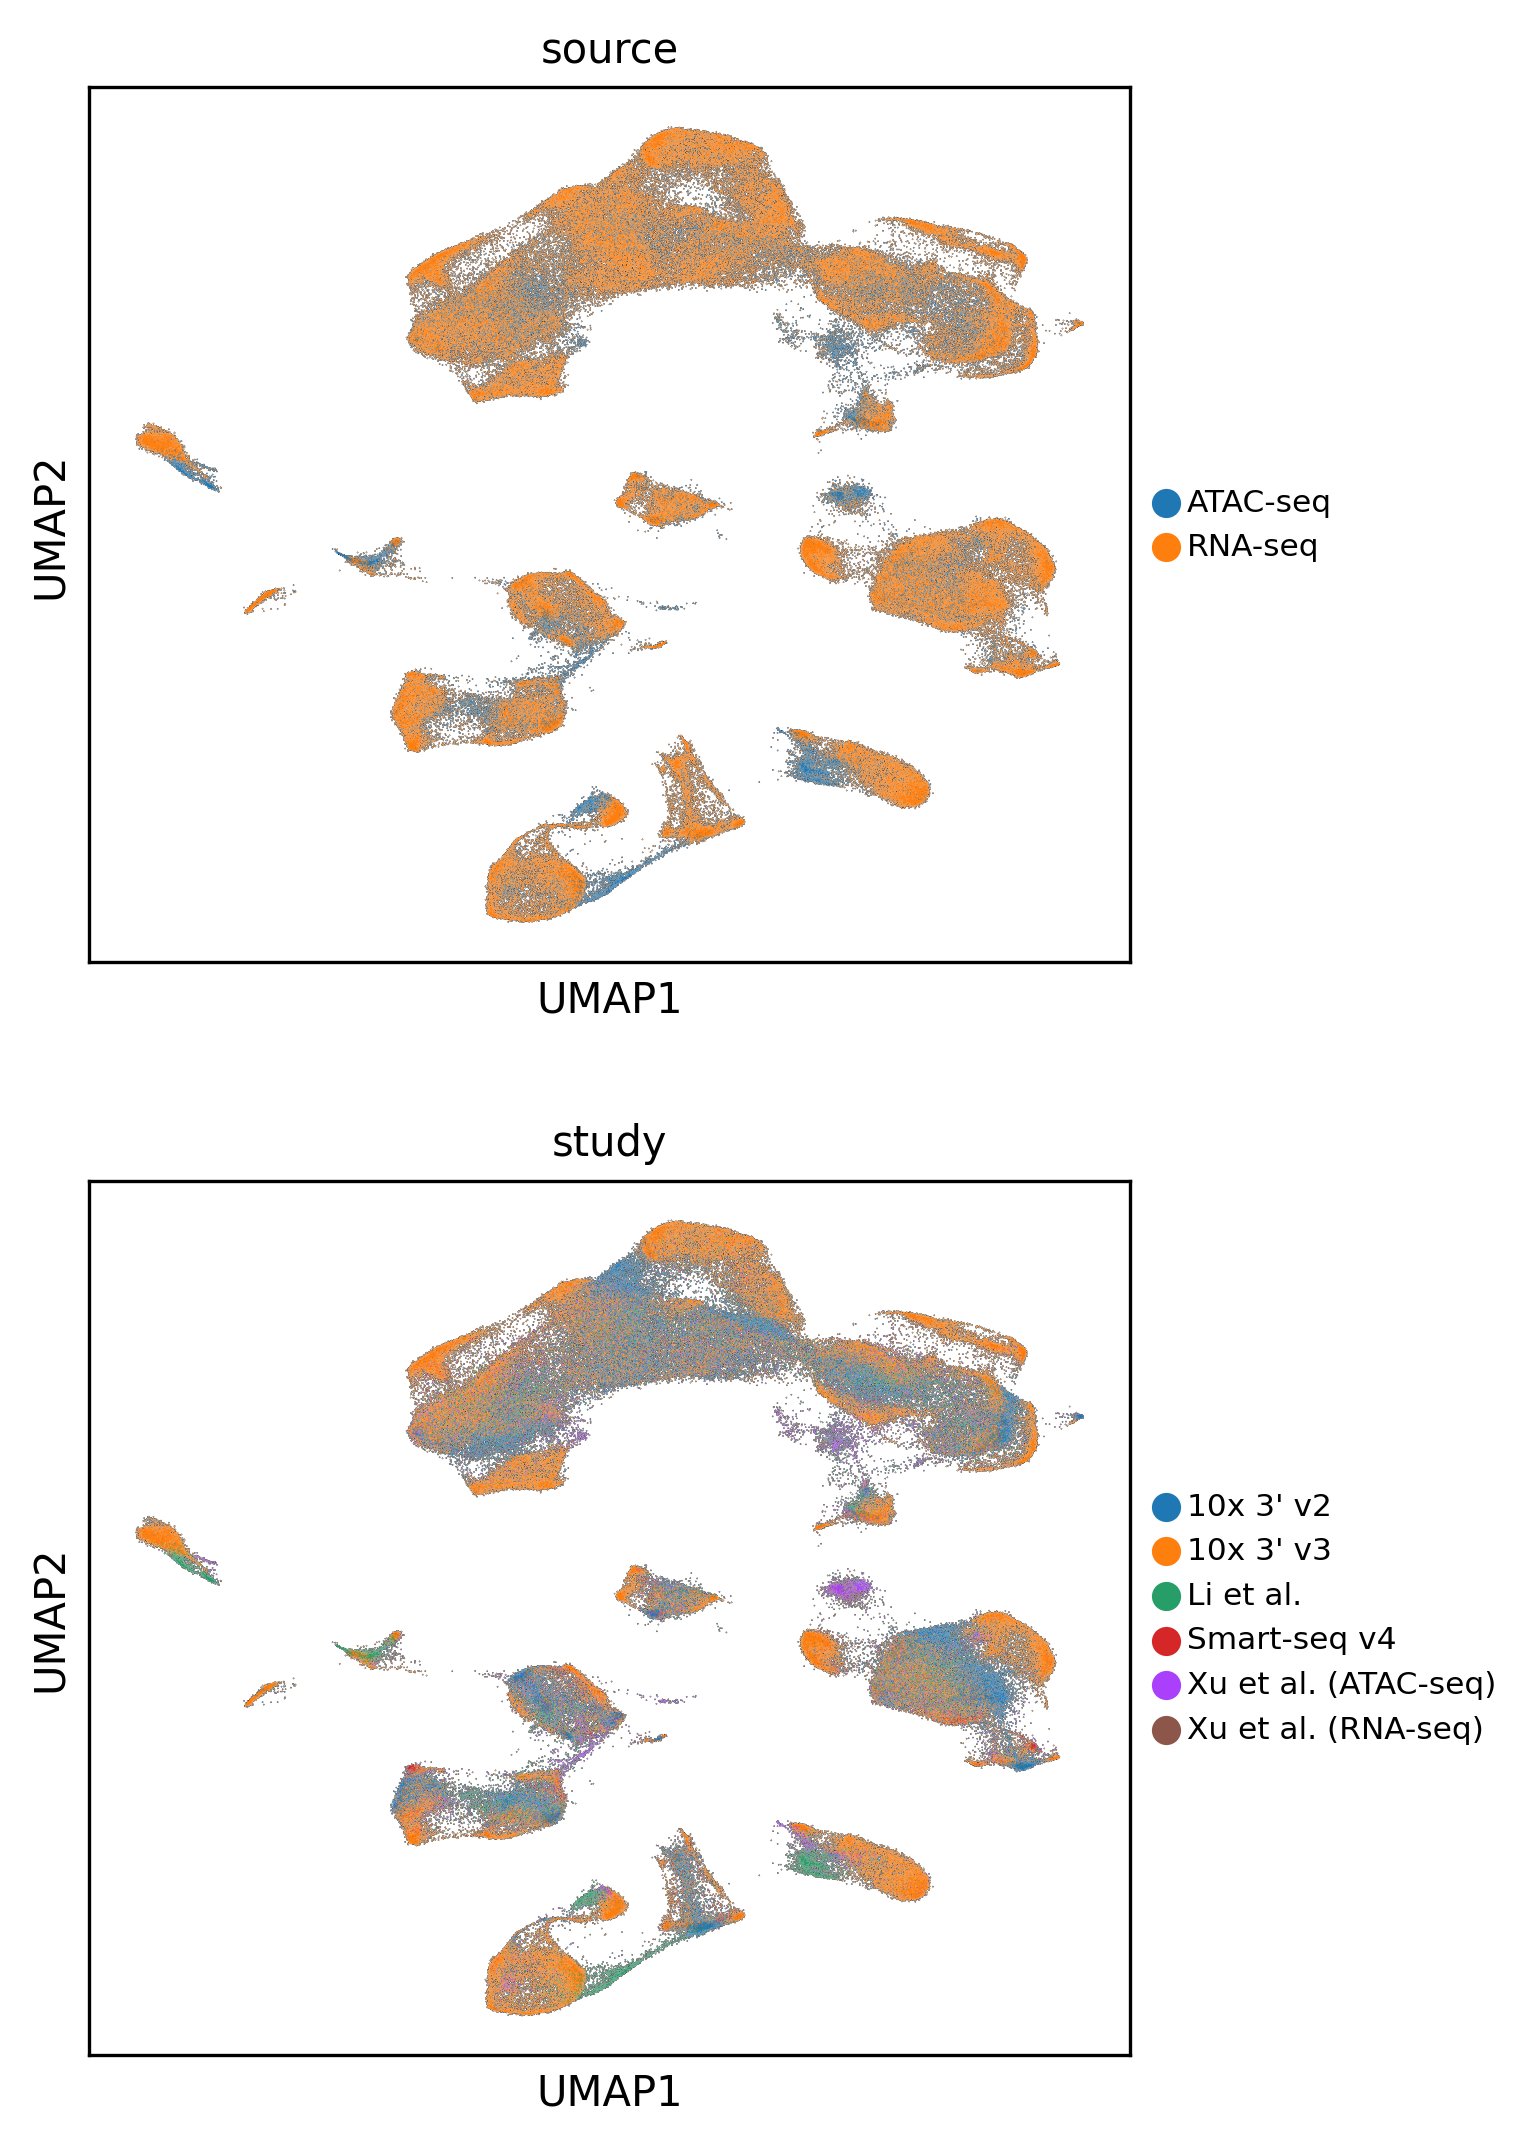

In [19]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150, fontsize=10, 
                     vector_friendly=True)
sc.pl.umap(adata, 
           color=['source','study'], 
           ncols=1, legend_fontsize=7.5, size=0.2, 
           add_outline=True)

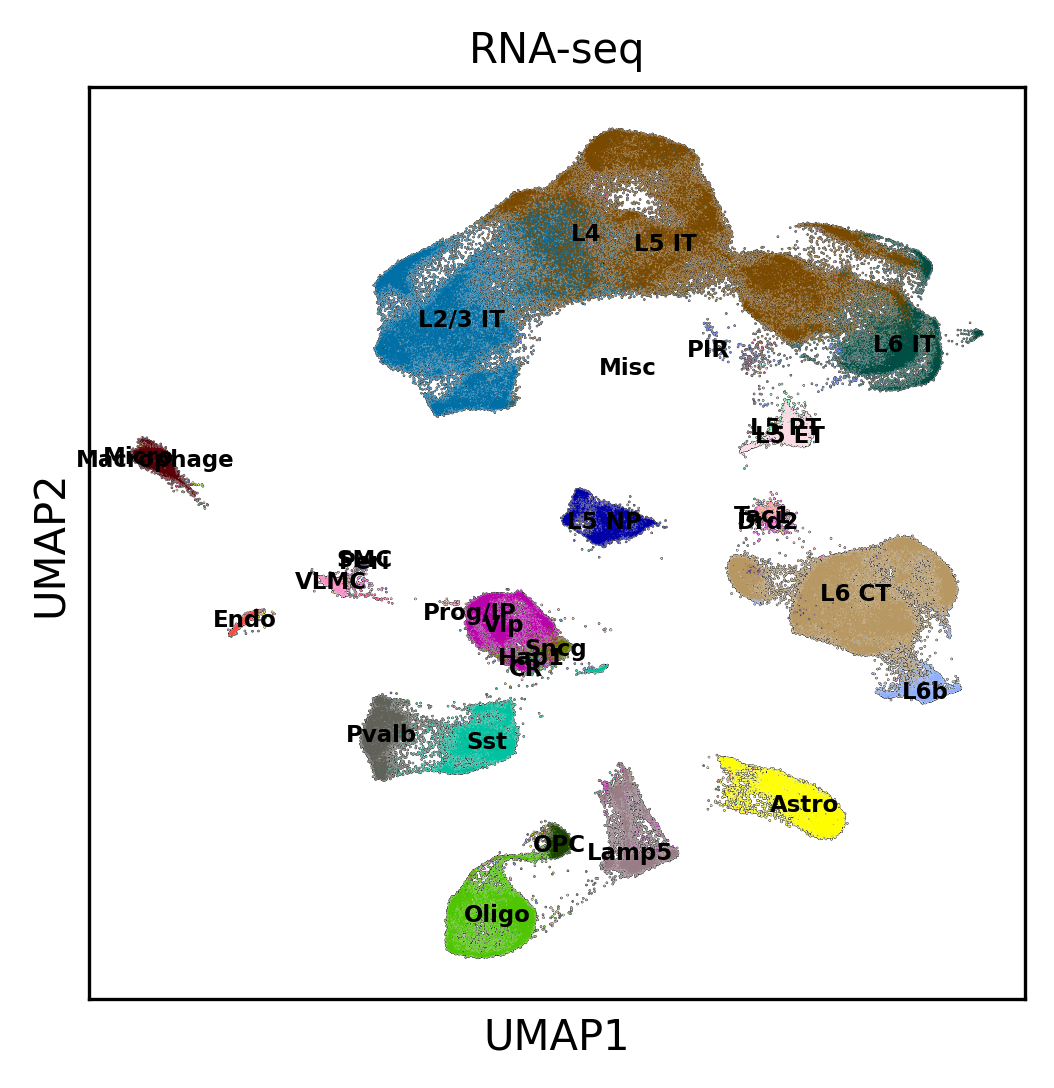

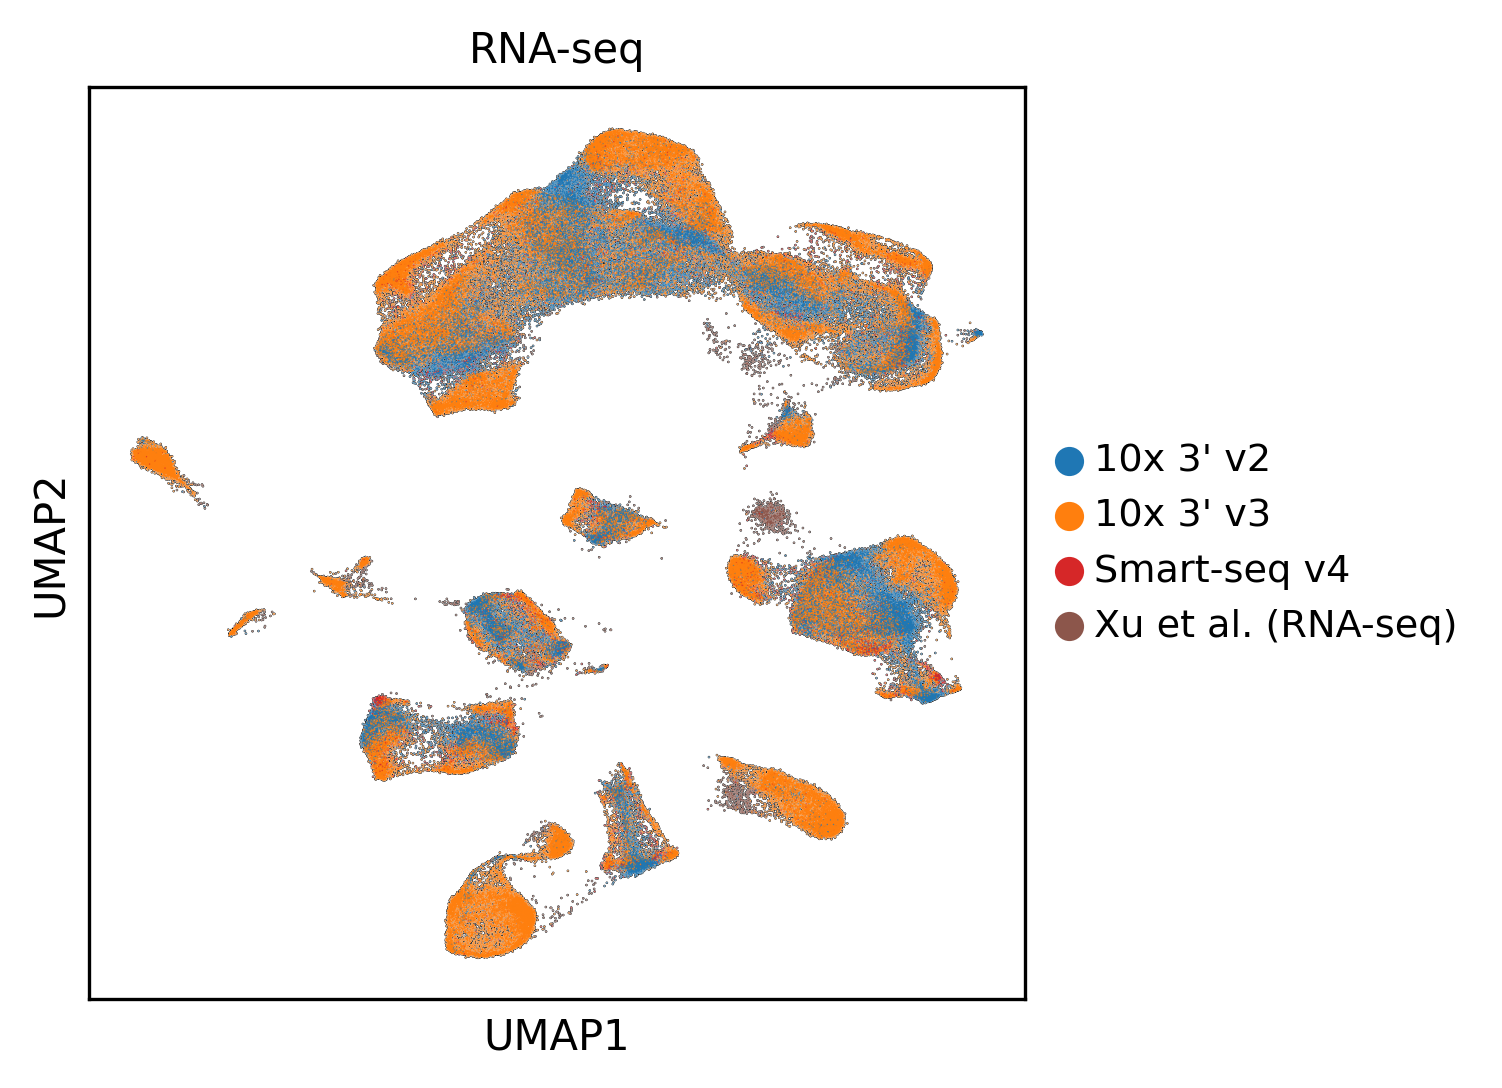

In [32]:
source = 'RNA-seq'
query = adata[adata.obs['source']==source]
sc.pl.umap(query, color=['cell_type'],
           ncols=1, title=source, legend_fontsize=5.5, size=0.5,
           add_outline=True, legend_loc='on data')

sc.pl.umap(query, color=['study'],
           ncols=1, title=source, size=0.5,
           add_outline=True)

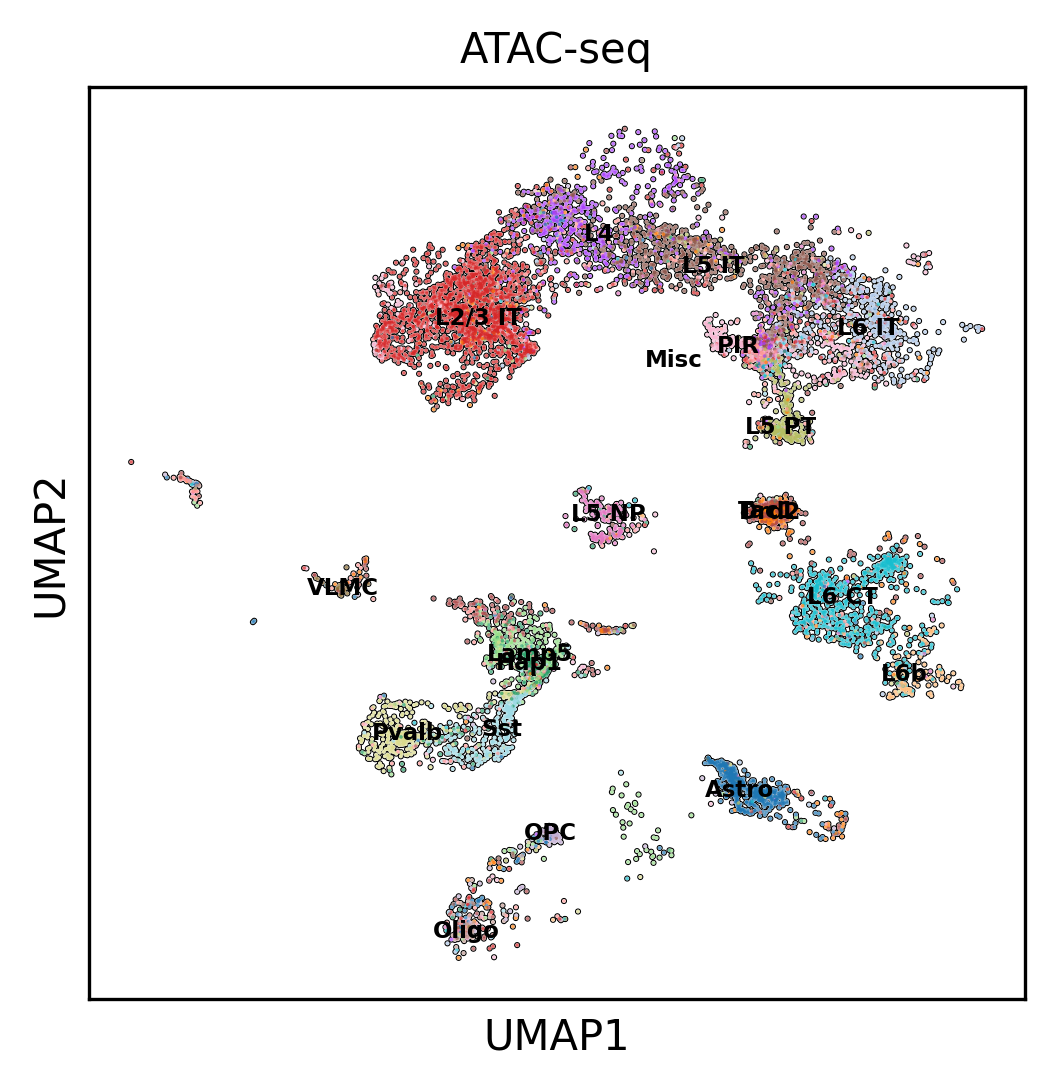

In [33]:
source = 'ATAC-seq'
query = adata[adata.obs['source']==source]
query = query[query.obs['study']=="Xu et al. (ATAC-seq)"]

sc.pl.umap(query, color=['cell_type'],
           ncols=1, title=source, legend_fontsize=5.5, size=3,
           add_outline=True, legend_loc='on data')

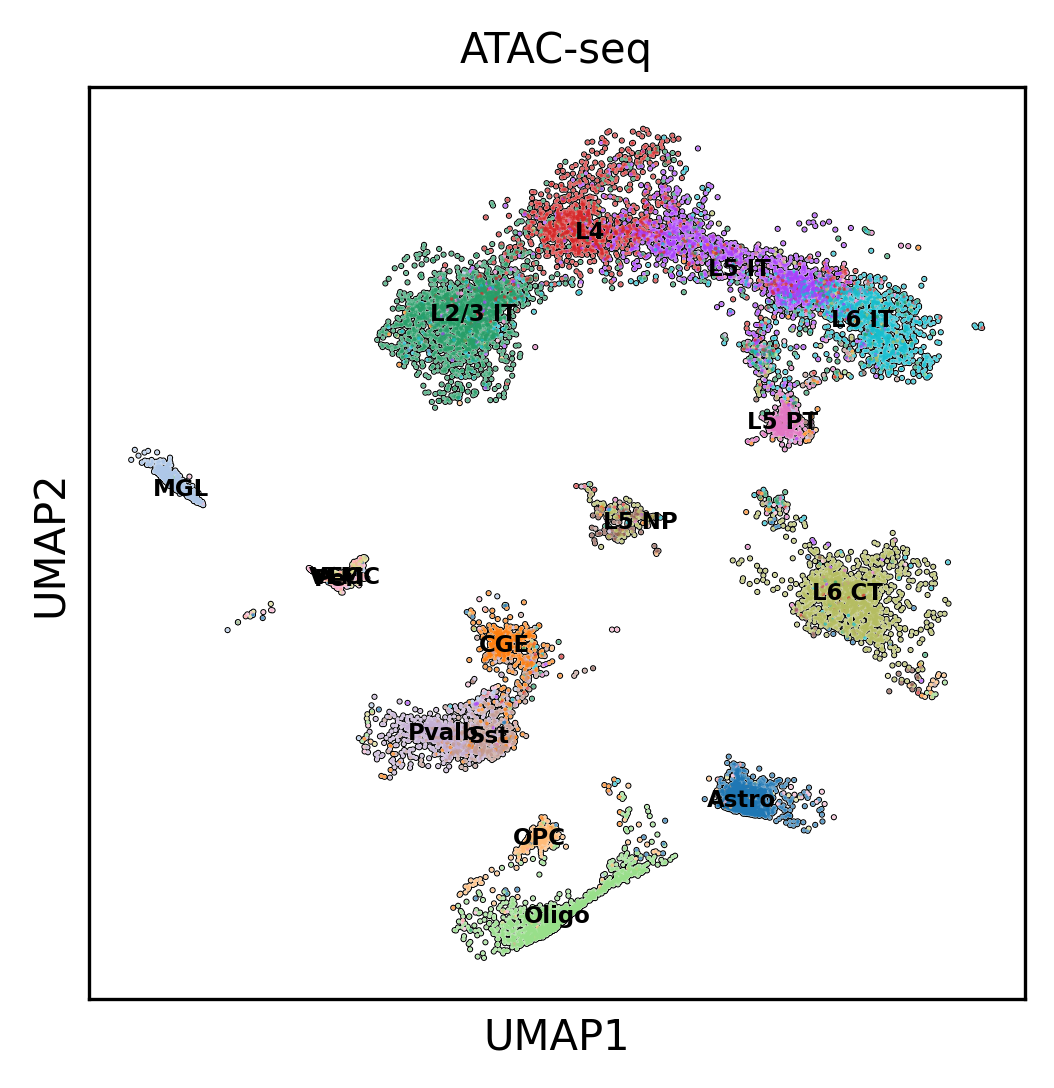

In [34]:
query = adata[adata.obs['source']==source]
query = query[query.obs['study']=='Li et al.']

sc.pl.umap(query, color=['cell_type'],
           ncols=1, title=source, legend_fontsize=5.5, size=3, 
           add_outline=True, legend_loc='on data')